## Synthetic sanity check examples

In this notebook, we show 2 synthetic sanity check examples: the chain dataset and the linear random graph example. The Latter example is used in the main text of the Shapley Flow paper

In [1]:
# limit the number of threads used by xgboost models
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["VECLIB_MAXIMUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"

# standard libaries
import sys
import copy
import dill
from collections import defaultdict
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from graphviz import Digraph

# flow specific packages
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f, create_linear_f
from flow import edge_credits2edge_credit
from on_manifold import OnManifoldExplainer, IndExplainer, FeatureAttribution
from linear_evaluation import get_error, get_indirect_effect_flow, get_effect_asv, get_effect_ind, get_effect_manifold, get_direct_effect_flow
from linear_evaluation import get_direct_effect_ground_truth, get_indirect_effect_ground_truth

np.random.seed(42)

## The chain experiment

In [2]:
n = 100
x1 = np.random.randn(n)
x4 = x3 = x2 = x1
 
X = pd.DataFrame.from_dict({'X1': x1, 'X2': x2, 'X3': x3, 'X4': x4}).loc[:, ['X1', 'X2', 'X3', 'X4']]
f = lambda x: x[:, 3] # f only depend on X4
f_d = pd.DataFrame.from_dict({'f': list(f(np.array(X)))})
pd.concat((X, f_d), 1)

,X1,X2,X3,X4,f
0,0.496714,0.496714,0.496714,0.496714,0.496714
1,-0.138264,-0.138264,-0.138264,-0.138264,-0.138264
2,0.647689,0.647689,0.647689,0.647689,0.647689
3,1.523030,1.523030,1.523030,1.523030,1.523030
4,-0.234153,-0.234153,-0.234153,-0.234153,-0.234153
...,...,...,...,...,...
95,-1.463515,-1.463515,-1.463515,-1.463515,-1.463515
96,0.296120,0.296120,0.296120,0.296120,0.296120
97,0.261055,0.261055,0.261055,0.261055,0.261055
98,0.005113,0.005113,0.005113,0.005113,0.005113


Assume the following causal graph with f only depends on $X_4$ (despite having connection to all 4 variables)

In [3]:
## setting up enviroment for graph viz
os.environ["PATH"] += os.pathsep + 'C:/Users/vivianjiang/anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin'

0it [00:00, ?it/s]


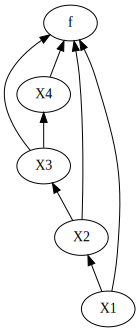

In [4]:
causal_links = CausalLinks()
target_name = 'f'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, lambda *args: f(np.vstack(args).T))
causal_links.add_causes_effects('X1', 'X2', lambda x: x)
causal_links.add_causes_effects('X2', 'X3', lambda x: x)
causal_links.add_causes_effects('X3', 'X4', lambda x: x)
causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, target_name=target_name)

causal_graph.draw()

## Explanation settings

In [5]:
nsamples = 100 # number of foreground samples to explain
nruns = 100 # number of monte carlo samples
sample_ind = 1
bg = X.fillna(X.mean()).sample(1) # background sample, no need for multiple sample because of the linearity axiom
fg = X[:nsamples] # foreground samples to explain

## Explain

In [7]:
explainer = OnManifoldExplainer(f, pd.concat([bg, X]), nruns=nruns, sigma_sq=1e-10) # small sigma only awards exact match
cf_on_manifold = explainer.shap_values(fg)

manifold bg samples: 100%|███████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.12it/s]


In [6]:
explainer = IndExplainer(f, bg, nruns=nruns)
cf_ind = explainer.shap_values(fg)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 15872.48it/s]


In [7]:
# second way of implemeting ASV beside using flow
explainer = OnManifoldExplainer(f, pd.concat([bg, X]), nruns=nruns, orderings=[[0, 1, 2, 3]], sigma_sq=1e-10)
cf_asv = explainer.shap_values(fg)

manifold bg samples: 100%|███████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.08it/s]


In [8]:
cf_flow = GraphExplainer(causal_graph, bg, nruns=nruns).shap_values(fg, rankdir='LR')

bruteforce sampling: 100%|█████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4359.80it/s]


## Sample explanation visualization

Shapley Flow


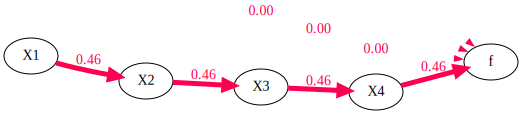

In [9]:
print('Shapley Flow')
cf_flow.fold_noise = True
g = cf_flow.draw(sample_ind, show_fg_val=False)

Observe that only Shapley Flow captures the direct and indirect effect of features for this simple chain dataset

On manifold SHAP


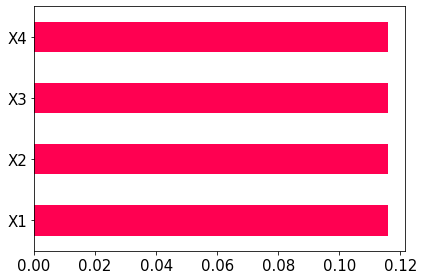

,X1,X2,X3,X4
1,0.115861,0.115861,0.115861,0.115861


In [12]:
print('On manifold SHAP')
cf_on_manifold.draw(sample_ind, show=False)
plt.tight_layout()
plt.show()
cf_on_manifold.print(sample_ind)

On manifold SHAP equally divide the influence.

Independent SHAP


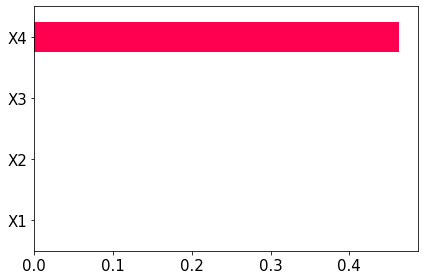

,X1,X2,X3,X4
1,0.0,0.0,0.0,0.463442


In [13]:
print('Independent SHAP')
cf_ind.draw(sample_ind, show=False)
plt.tight_layout()
plt.show()
cf_ind.print(sample_ind)

Independent SHAP only shows the direct impact.

ASV (note: only non-zero attribution nodes are shown)


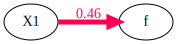

,X1,X2,X3,X4
1,0.463442,0.0,0.0,0.0


In [14]:
print('ASV (note: only non-zero attribution nodes are shown)')
cf_flow.fold_noise = False
cf_flow.draw_asv(sample_ind, show_fg_val=False)
# alternative implementation of ASV
cf_asv.print(sample_ind)

ASV only shows the indirect impact

## Linear random graph example

### Dataset and Model

10 nodes


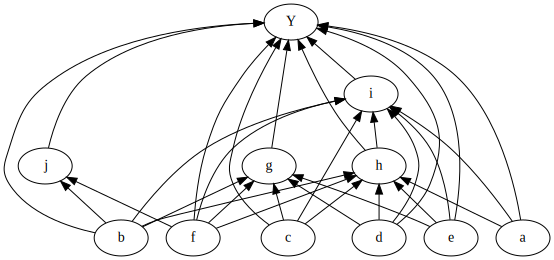

In [16]:
def build_random_linear_graph(n_nodes=10):
    nodes = []
    name = 'a'
    for _ in range(n_nodes):
        len_args = 0 if len(nodes) == 0 else np.random.choice(len(nodes))
        args = [nodes[i] for i in np.random.choice(len(nodes), len_args, replace=False)]
        weights, b = np.random.randn(len_args), np.random.randn() # linear model weight and bias
        node = Node(name, lambda *args: sum([w * arg for w, arg in zip(weights, args)]) + b, args)
        name = chr(ord(name) + 1)
        nodes.append(node)

    print(len(nodes), "nodes")
    args = nodes # all nodes are input to Y
    weights, b = np.random.randn(len(args)), np.random.randn()
    n_irrelevant_features = 3 # np.random.choice(len(nodes)) # todo: use random later for more graphs
    if n_irrelevant_features != 0:
        drop_features = np.random.choice(len(nodes), n_irrelevant_features, replace=False)
        weights[drop_features] = 0
    
    target_node = Node('Y', lambda *args: sum([w * arg for w, arg in zip(weights, args)]) + b, 
                       args, is_target_node=True)
    nodes.append(target_node)
    
    graph = Graph(nodes)
    return graph

graph = build_random_linear_graph()
graph.draw()

In [17]:
# build a linear dataset according to the graph
n = 1000 # number of examples
sources = get_source_nodes(graph)
target_node = [node for node in graph if node.is_target_node][0]
d = dict((node.name, np.random.randn(n)) for node in sources)
eval_graph(graph, d)

X_linear = pd.DataFrame.from_dict({node.name:node.val for node in graph if not node.is_target_node}).loc[:,[node.name for node in target_node.args]]
f = lambda x: target_node.f(*[x[:,i] for i in range(x.shape[1])])
f_d = pd.DataFrame.from_dict({'Y': list(f(np.array(X_linear)))})
pd.concat((X_linear, f_d), 1)

,a,b,c,d,e,f,g,h,i,j,Y
0,-0.587154,-1.160325,-0.019623,-0.016536,1.770168,-0.011724,-1.783746,-3.519216,0.054351,-1.306730,-4.403898
1,-0.532172,0.851354,0.828455,0.252060,-2.640898,-0.460832,-0.304800,3.027210,-2.224545,-1.153746,7.398649
2,0.385473,-0.620364,-0.926713,-0.376132,-0.323438,-0.373430,-1.147198,-0.621615,0.255586,-1.265667,-2.115968
3,0.412981,-0.736412,1.287982,1.749224,0.110390,0.003881,-1.668771,-0.191484,0.071051,-1.274492,-1.430981
4,-0.292955,0.579504,-0.422812,-1.018250,0.507421,1.622175,-2.899721,-4.615311,-4.265526,-1.174419,4.141029
...,...,...,...,...,...,...,...,...,...,...,...
995,-0.284290,0.328652,-0.479051,-0.333779,0.520488,0.957234,-2.201961,-3.363571,-3.037740,-1.193496,2.346837
996,0.753404,0.900229,-1.773504,-1.012273,-0.817928,-0.582887,0.020210,-0.166147,-1.261848,-1.150029,1.670886
997,-2.063885,-0.622378,-0.690387,-0.789347,-0.533855,0.389342,-2.141011,-1.560918,-2.280738,-1.265820,2.511916
998,0.754062,0.478090,0.004093,0.102075,-0.653880,0.826249,-2.031501,-1.362037,-2.485987,-1.182132,3.228005


### Explanation settings

In [18]:
nsamples = 100 # paper: 1000 samples
sample_ind = 10 # example to visualize
bg = X_linear.fillna(X_linear.mean()).sample(1) # background sample, no need for multiple sample because of the linearity axiom
fg = X_linear[:nsamples] # foreground samples to explain

### Explain

Linear models only need 1 Monte Carlo sampling run for SHAP to converge.

In [19]:
cf_flow_linear = GraphExplainer(graph, bg, nruns=1).shap_values(fg)

bruteforce sampling: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.21it/s]


In [20]:
bg_on_manifold = X_linear.fillna(X_linear.mean()).sample(100) # used to learn conditional dependence
explainer = OnManifoldExplainer(f, pd.concat([bg, bg_on_manifold]), nruns=10) # need > 1 run b/c conditional expectation is non-linear
cf_on_manifold_linear = explainer.shap_values(fg)

manifold bg samples: 100%|███████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.50it/s]


In [21]:
explainer = IndExplainer(f, bg, nruns=1)
cf_ind_linear = explainer.shap_values(fg)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.21it/s]


### Sample explanation visualization

Shapley Flow


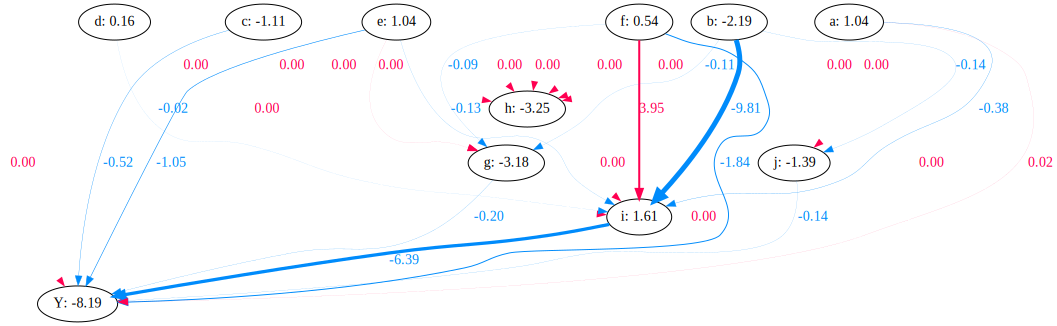

<AGraph <Swig Object of type 'Agraph_t *' at 0x0000016587BFDB40>>

In [22]:
print("Shapley Flow")
cf_flow_linear.fold_noise = True
cf_flow_linear.draw(sample_ind)

On manifold SHAP


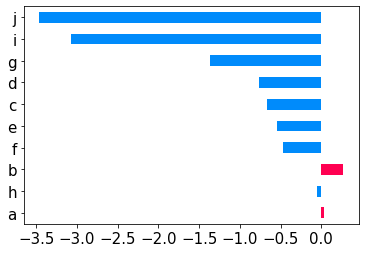

In [23]:
print("On manifold SHAP")
cf_on_manifold_linear.draw(sample_ind)

Independent SHAP


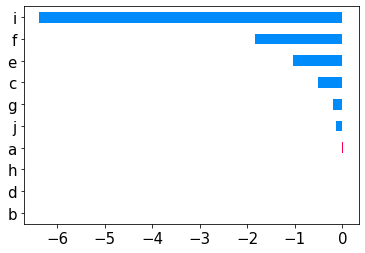

In [24]:
print("Independent SHAP")
cf_ind_linear.draw(sample_ind)

ASV (note: only non-zero attribution nodes are shown)


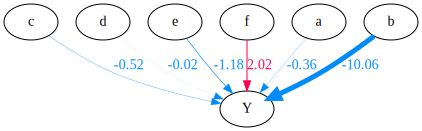

<AGraph <Swig Object of type 'Agraph_t *' at 0x00000165880BFCF0>>

In [25]:
print('ASV (note: only non-zero attribution nodes are shown)')
cf_flow_linear.fold_noise = False
cf_flow_linear.draw_asv(sample_ind, show_fg_val=False)

### Calculate difference with the ground truth

In [26]:
gt = get_direct_effect_ground_truth(cf_flow_linear.graph)
theta_ind = get_effect_ind(cf_ind_linear)
theta_manifold = get_effect_manifold(cf_on_manifold_linear)
theta_asv = get_effect_asv(cf_flow_linear)
theta_flow = get_direct_effect_flow(cf_flow_linear)

gt_indirect = get_indirect_effect_ground_truth(cf_flow_linear.graph)
theta_flow_indirect = get_indirect_effect_flow(cf_flow_linear)

### Direct effect

Note that both Independent SHAP and Shapley Flow makes no error.

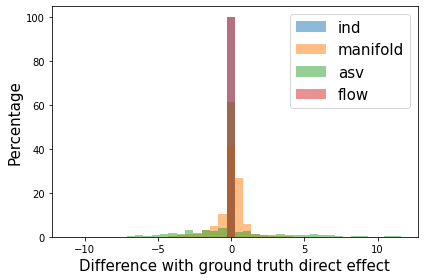

       ind: 0.0 ($\pm$ 0.0)
  manifold: 0.6 ($\pm$ 0.7)
       asv: 1.2 ($\pm$ 2.0)
      flow: 0.0 ($\pm$ 0.0)


In [27]:
errors = {
    'ind': get_error(gt, theta_ind),
    'manifold': get_error(gt, theta_manifold),
    'asv': get_error(gt, theta_asv),
    'flow': get_error(gt, theta_flow)
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] #get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.5, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.xlabel('Difference with ground truth direct effect', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.tight_layout()
plt.show()

for k, v in errors.items():
    print(f"{k:>10s}: {np.abs(v).mean().round(1)} ($\pm$ {np.abs(v).std().round(1)})")


### Indirect effect

Note that only Shapley Flow has 0 error. ASV makes error on non-source nodes.

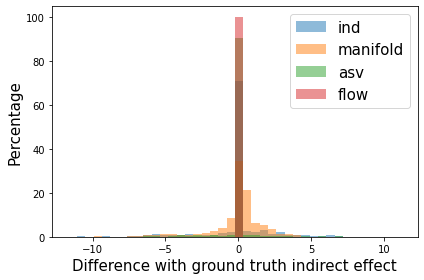

       ind: 0.9 ($\pm$ 1.8)
  manifold: 1.1 ($\pm$ 1.5)
       asv: 0.3 ($\pm$ 1.2)
      flow: 0.0 ($\pm$ 0.0)


In [28]:
errors = {
    'ind': get_error(gt_indirect, theta_ind),
    'manifold': get_error(gt_indirect, theta_manifold),
    'asv': get_error(gt_indirect, theta_asv),
    'flow': get_error(gt_indirect, theta_flow_indirect)
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] #get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.5, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.xlabel('Difference with ground truth indirect effect', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.tight_layout()
plt.show()

for k, v in errors.items():
    print(f"{k:>10s}: {np.abs(v).mean().round(1)} ($\pm$ {np.abs(v).std().round(1)})")

### Indirect effect on source nodes

Note that both ASV and Shapley Flow makes no error.

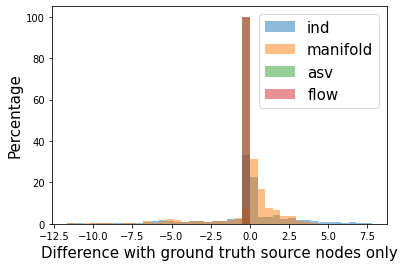

       ind: 1.5 ($\pm$ 2.1)
  manifold: 1.4 ($\pm$ 1.7)
       asv: 0.0 ($\pm$ 0.0)
      flow: 0.0 ($\pm$ 0.0)


In [29]:
sources = get_source_nodes(graph)
errors = {
    'ind': get_error(gt_indirect, theta_ind, sources),
    'manifold': get_error(gt_indirect, theta_manifold, sources),
    'asv': get_error(gt_indirect, theta_asv, sources),
    'flow': get_error(gt_indirect, theta_flow_indirect, sources)
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] #get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.5, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.xlabel('Difference with ground truth source nodes only', fontsize=15)
plt.show()

for k, v in errors.items():
    print(f"{k:>10s}: {np.abs(v).mean().round(1)} ($\pm$ {np.abs(v).std().round(1)})")